In [1]:
import pandas as pd

# Load CSV files (replace with your actual file paths)
us = pd.read_csv('USvideos.csv')
in_videos = pd.read_csv('INvideos.csv')

# Add region column
us['region'] = 'US'
in_videos['region'] = 'IN'

# Combine datasets
df = pd.concat([us, in_videos], ignore_index=True)

# Standardize column names
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

# Convert date fields
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%m.%d', errors='coerce')
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# Fill missing tags
df['tags'] = df['tags'].fillna('')

# Drop duplicates
df.drop_duplicates(inplace=True)

df.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,2kyS6SvSYSE,NaT,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,NaT,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US
2,5qpjK5DgCt4,NaT,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,US
3,puqaWrEC7tY,NaT,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,US
4,d380meD0W0M,NaT,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,US


In [2]:
from textblob import TextBlob

# Define sentiment function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply to title and tags
df['title_sentiment'] = df['title'].astype(str).apply(get_sentiment)
df['tags_sentiment'] = df['tags'].astype(str).apply(get_sentiment)

# Categorize sentiment (optional)
df['title_sentiment_label'] = df['title_sentiment'].apply(
    lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral'
)

df[['title', 'title_sentiment', 'title_sentiment_label']].head()


,title,title_sentiment,title_sentiment_label
0,WE WANT TO TALK ABOUT OUR MARRIAGE,0.00,neutral
1,The Trump Presidency: Last Week Tonight with J...,0.00,neutral
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",0.00,neutral
3,Nickelback Lyrics: Real or Fake?,-0.75,negative
4,I Dare You: GOING BALD!?,0.00,neutral


In [3]:
import sqlite3

# Save to SQLite
conn = sqlite3.connect('youtube_trending.db')
df.to_sql('videos', conn, if_exists='replace', index=False)

# SQL Query: Avg Views by Category and Region
query = '''
SELECT category_id, region, AVG(views) as avg_views
FROM videos
GROUP BY category_id, region
ORDER BY avg_views DESC
'''

avg_views_df = pd.read_sql(query, conn)
avg_views_df.head()


,category_id,region,avg_views
0,10,US,6.204776e+06
1,20,IN,3.606369e+06
2,30,IN,3.191953e+06
3,1,US,3.101917e+06
4,29,US,2.963884e+06


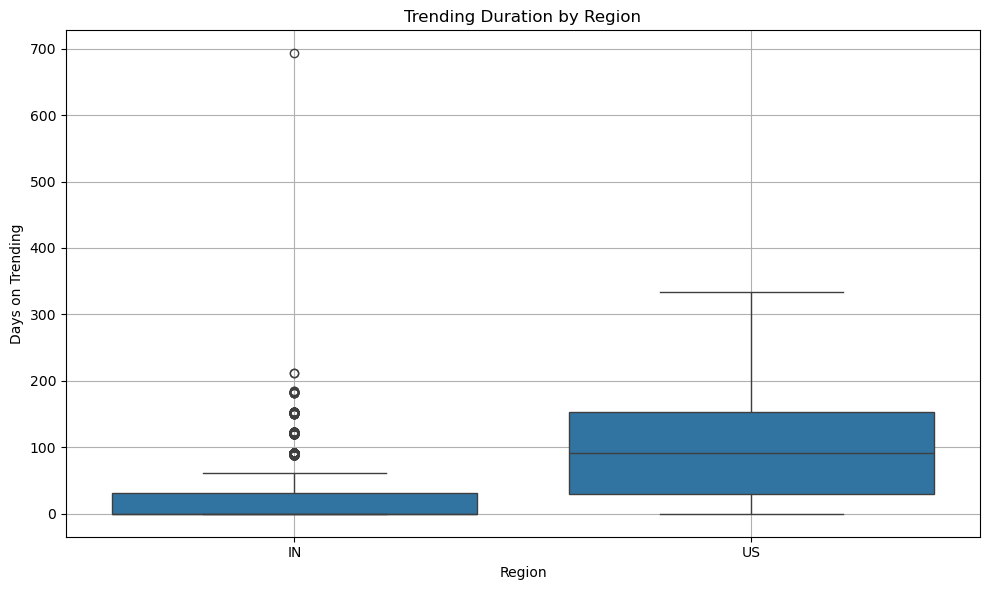

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trending duration = max - min trending date per video
df['video_id'] = df['video_id'].astype(str)
duration_df = df.groupby(['video_id', 'region'])['trending_date'].agg(['min', 'max']).reset_index()
duration_df['trending_days'] = (duration_df['max'] - duration_df['min']).dt.days

# Remove nulls
duration_df = duration_df.dropna(subset=['trending_days'])

# Boxplot of trending duration by region
plt.figure(figsize=(10,6))
sns.boxplot(data=duration_df, x='region', y='trending_days')
plt.title("Trending Duration by Region")
plt.ylabel("Days on Trending")
plt.xlabel("Region")
plt.grid(True)
plt.tight_layout()
plt.show()


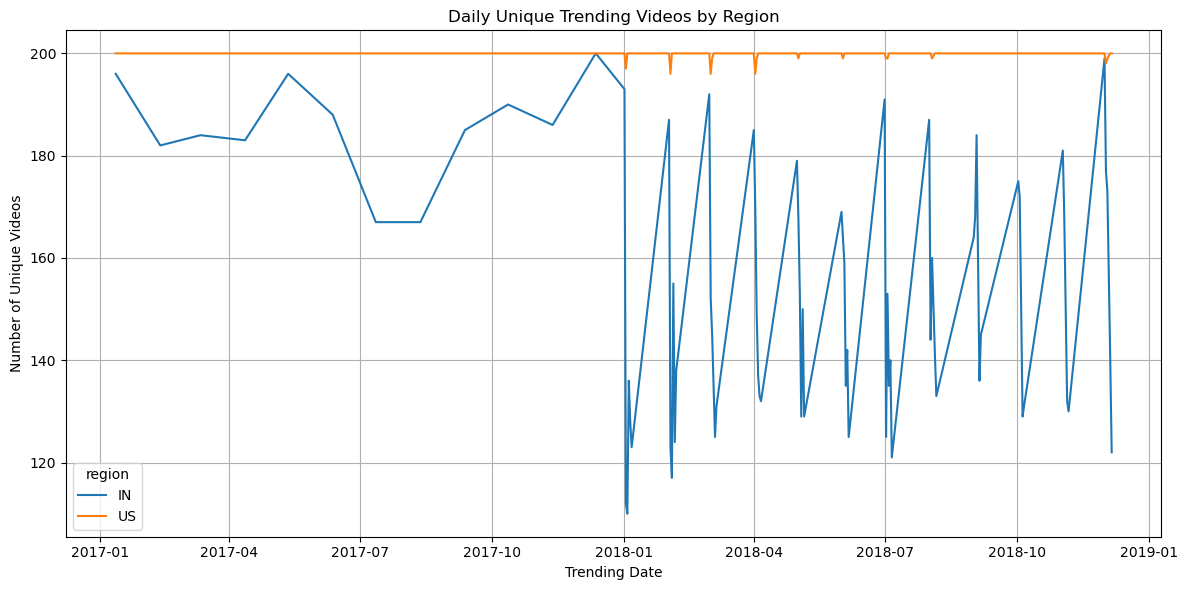

In [5]:
daily_trends = df.groupby(['trending_date', 'region'])['video_id'].nunique().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_trends, x='trending_date', y='video_id', hue='region')
plt.title('Daily Unique Trending Videos by Region')
plt.xlabel('Trending Date')
plt.ylabel('Number of Unique Videos')
plt.grid(True)
plt.tight_layout()
plt.show()


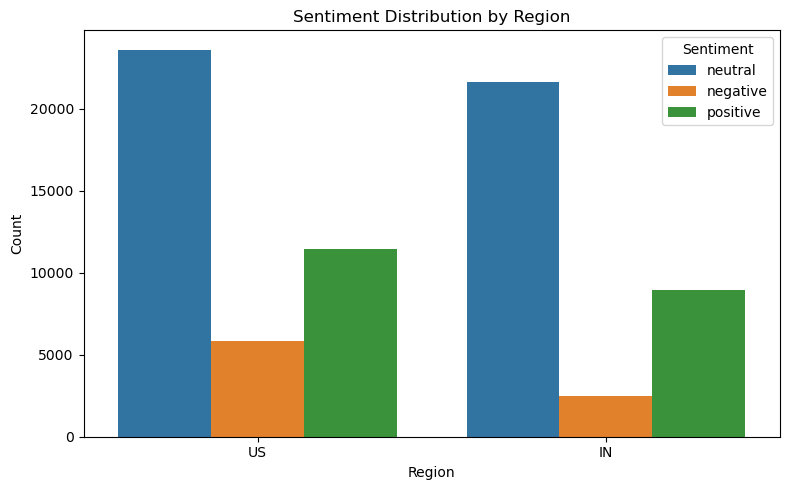

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='region', hue='title_sentiment_label')
plt.title('Sentiment Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


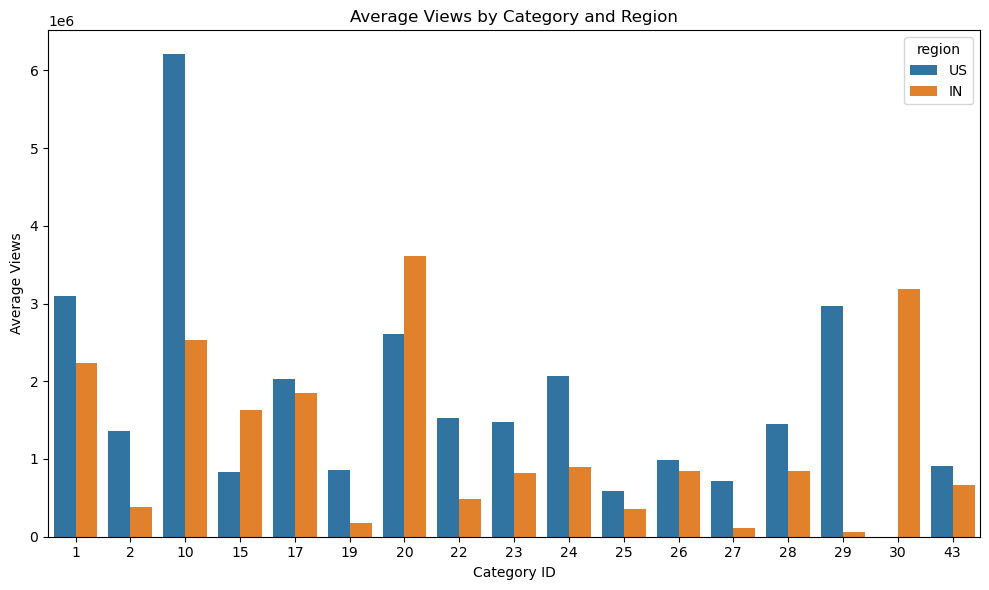

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(data=avg_views_df, x='category_id', y='avg_views', hue='region')
plt.title('Average Views by Category and Region')
plt.xlabel('Category ID')
plt.ylabel('Average Views')
plt.tight_layout()
plt.show()


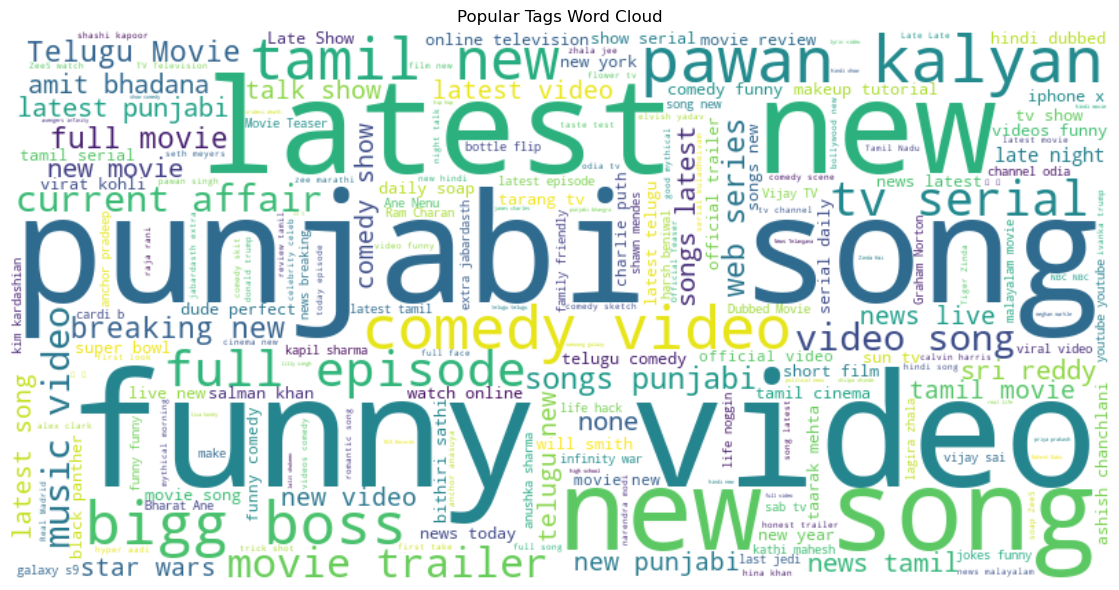

In [8]:
from wordcloud import WordCloud

tags_text = ' '.join(df['tags'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popular Tags Word Cloud')
plt.tight_layout()
plt.show()


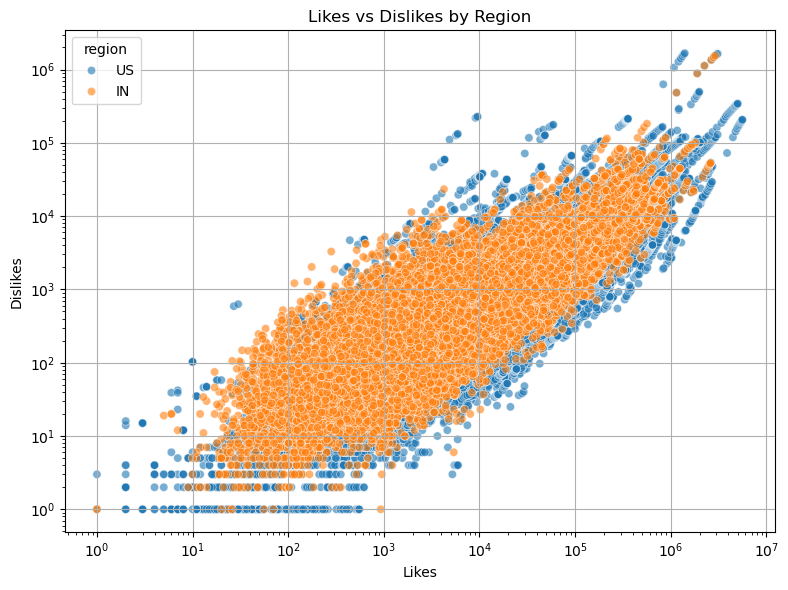

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='likes', y='dislikes', hue='region', alpha=0.6)
plt.title('Likes vs Dislikes by Region')
plt.xlabel('Likes')
plt.ylabel('Dislikes')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


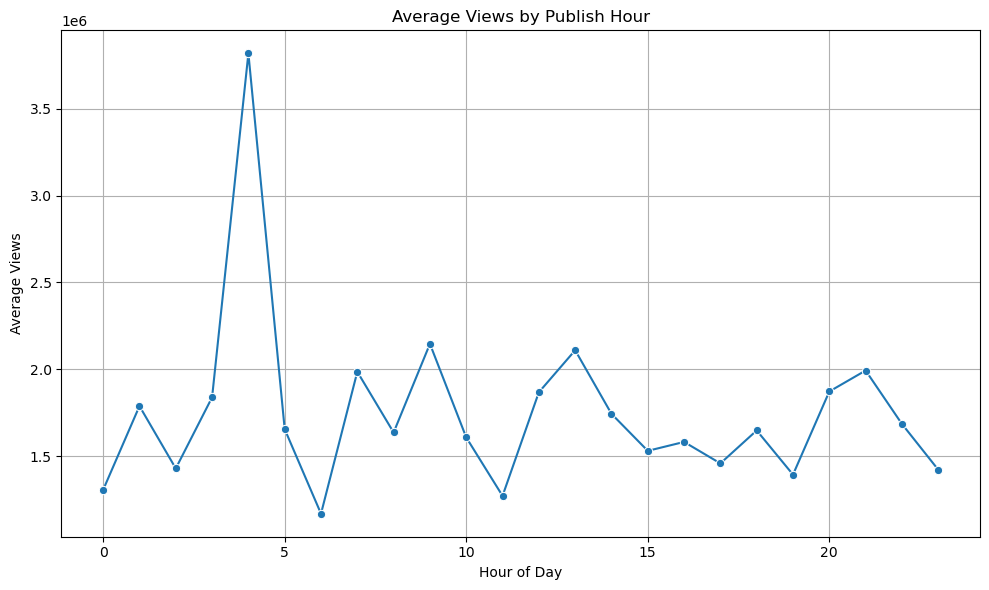

In [10]:
df['publish_hour'] = df['publish_time'].dt.hour
hourly_views = df.groupby('publish_hour')['views'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_views, x='publish_hour', y='views', marker='o')
plt.title('Average Views by Publish Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Views')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Export sentiment results
df[['video_id', 'title', 'region', 'title_sentiment', 'title_sentiment_label']].to_excel('sentiment_analysis.xlsx', index=False)

# Export category-wise average views (SQL result)
avg_views_df.to_excel('category_avg_views.xlsx', index=False)

# Export trending duration
duration_df.to_excel('trending_duration.xlsx', index=False)


In [12]:
df[['video_id', 'title', 'region', 'title_sentiment', 'title_sentiment_label']].to_csv('sentiment_analysis.csv', index=False)
avg_views_df.to_csv('category_avg_views.csv', index=False)
duration_df.to_csv('trending_duration.csv', index=False)


In [13]:
with pd.ExcelWriter('youtube_dashboard_data.xlsx') as writer:
    df[['video_id', 'title', 'region', 'title_sentiment', 'title_sentiment_label']].to_excel(writer, sheet_name='Sentiment', index=False)
    avg_views_df.to_excel(writer, sheet_name='Avg Views by Category', index=False)
    duration_df.to_excel(writer, sheet_name='Trending Duration', index=False)


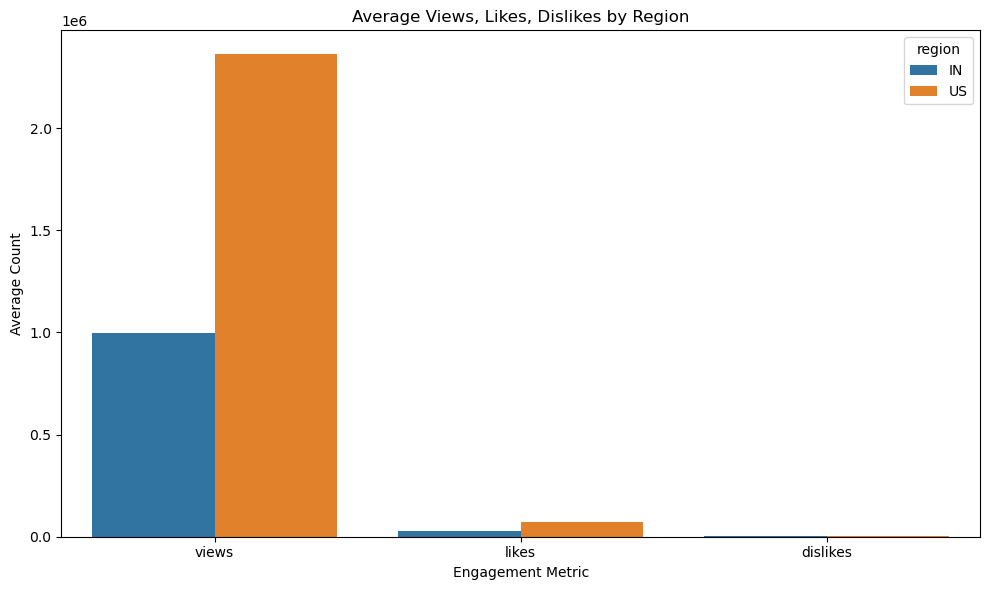

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate average views, likes, dislikes per region
agg_metrics = df.groupby('region')[['views', 'likes', 'dislikes']].mean().reset_index()

# Melt for grouped barplot
melted = agg_metrics.melt(id_vars='region', var_name='metric', value_name='average')

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='metric', y='average', hue='region')
plt.title("Average Views, Likes, Dislikes by Region")
plt.ylabel("Average Count")
plt.xlabel("Engagement Metric")
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import os

# List of country files and their region codes
country_files = {
    'US': 'USvideos.csv',
    'IN': 'INvideos.csv',
    'GB': 'GBvideos.csv',
    'CA': 'CAvideos.csv',
    'DE': 'DEvideos.csv',
    'FR': 'FRvideos.csv'
}

# Load and tag all countries
dataframes = []
for region, file in country_files.items():
    df = pd.read_csv(file)
    df['region'] = region
    dataframes.append(df)

# Combine all into one
df = pd.concat(dataframes, ignore_index=True)

# Clean column names
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

# Convert to datetime
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# Fill tags, drop duplicates
df['tags'] = df['tags'].fillna('')
df.drop_duplicates(inplace=True)


C:\Users\dell3\AppData\Local\Temp\ipykernel_30708\608224879.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')


In [11]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df['title_sentiment'] = df['title'].apply(get_sentiment)

df['title_sentiment_label'] = df['title_sentiment'].apply(
    lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral'
)


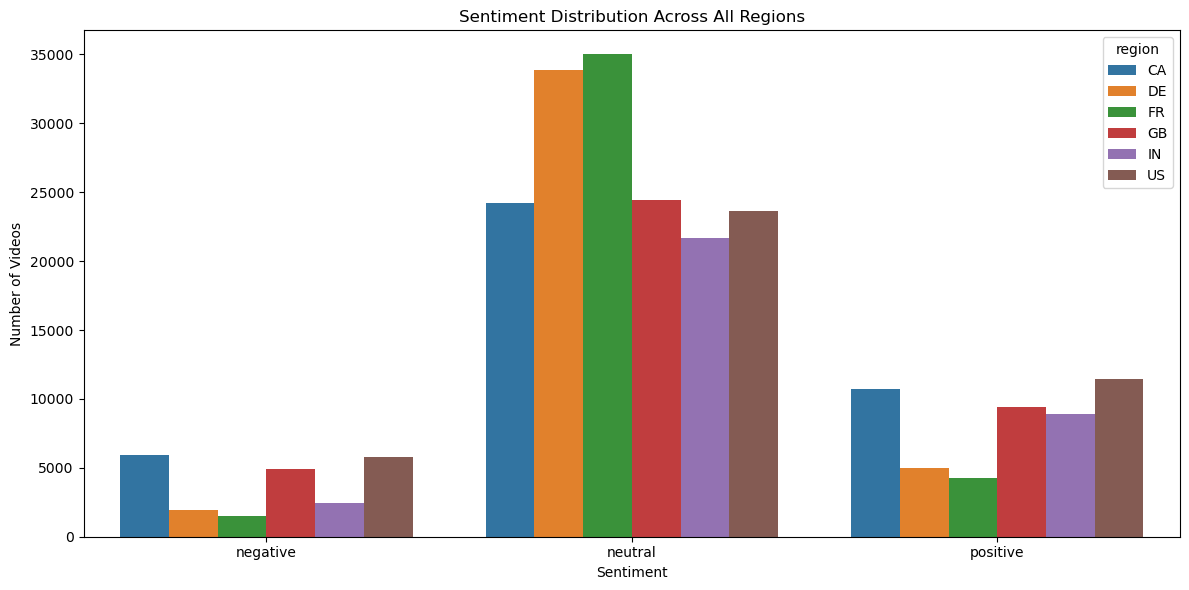

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_dist = df.groupby(['region', 'title_sentiment_label']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(data=sentiment_dist, x='title_sentiment_label', y='count', hue='region')
plt.title("Sentiment Distribution Across All Regions")
plt.xlabel("Sentiment")
plt.ylabel("Number of Videos")
plt.tight_layout()
plt.show()


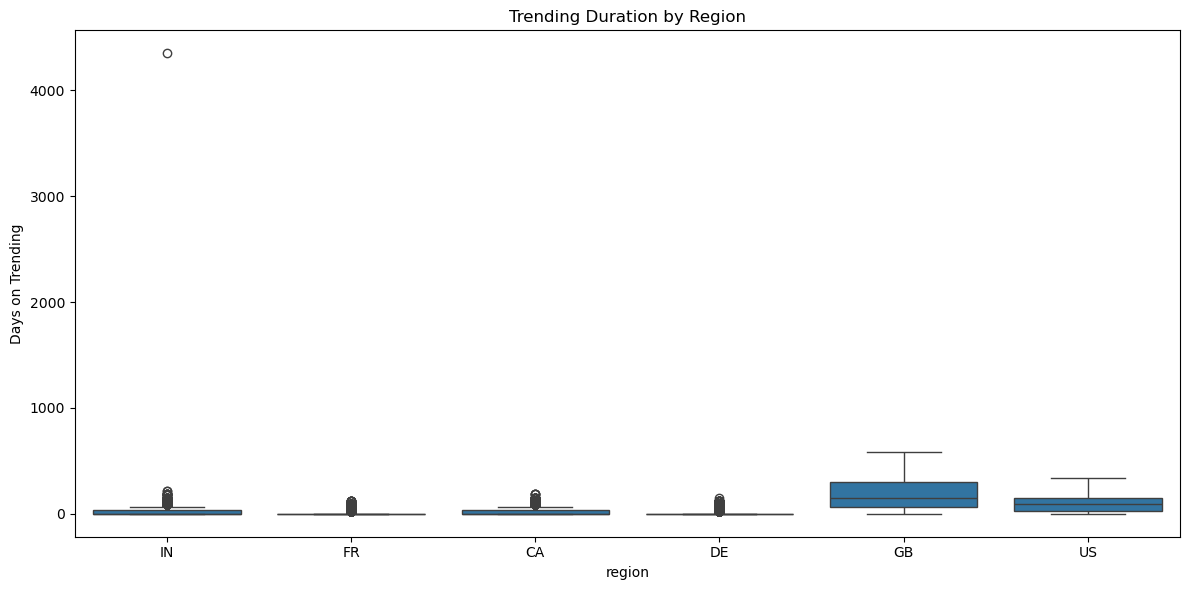

In [13]:
df['video_id'] = df['video_id'].astype(str)

duration_df = df.groupby(['video_id', 'region'])['trending_date'].agg(['min', 'max']).reset_index()
duration_df['trending_days'] = (duration_df['max'] - duration_df['min']).dt.days

plt.figure(figsize=(12,6))
sns.boxplot(data=duration_df, x='region', y='trending_days')
plt.title("Trending Duration by Region")
plt.ylabel("Days on Trending")
plt.tight_layout()
plt.show()


In [16]:
category_map = {
    1: 'Film & Animation',
    2: 'Autos & Vehicles',
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    20: 'Gaming',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology',
    29: 'Nonprofits & Activism'
}


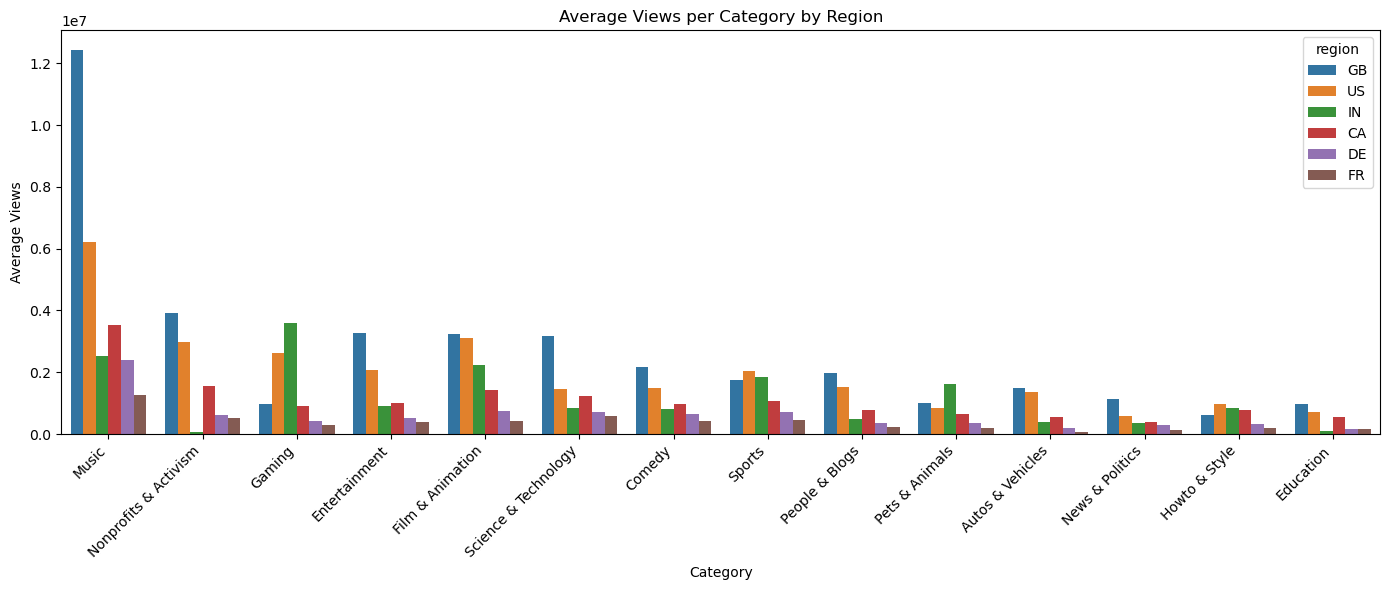

In [17]:
avg_views_df['category_name'] = avg_views_df['category_id'].map(category_map)

plt.figure(figsize=(14,6))
sns.barplot(data=avg_views_df, x='category_name', y='avg_views', hue='region')
plt.xticks(rotation=45, ha='right')
plt.title("Average Views per Category by Region")
plt.xlabel("Category")
plt.ylabel("Average Views")
plt.tight_layout()
plt.show()


In [18]:
query = '''
SELECT 
    category_id, 
    region, 
    AVG(views) AS avg_views
FROM videos
GROUP BY category_id, region
ORDER BY avg_views DESC
'''

avg_views_df = pd.read_sql(query, conn)


In [19]:
import json

# Load category mapping from YouTube category JSON
with open('US_category_id.json') as f:
    data = json.load(f)

category_map = {}
for item in data['items']:
    category_map[int(item['id'])] = item['snippet']['title']

# Map category names
avg_views_df['category_name'] = avg_views_df['category_id'].map(category_map)


In [20]:
sentiment_dist.to_excel('sentiment_by_region.xlsx', index=False)
duration_df.to_excel('duration_by_region.xlsx', index=False)
avg_views_df.to_excel('avg_views_by_category_region.xlsx', index=False)


In [22]:
import pandas as pd

with pd.ExcelWriter('YouTube_Analytics_Report.xlsx', engine='xlsxwriter') as writer:
    sentiment_dist.to_excel(writer, sheet_name='Sentiment by Region', index=False)
    duration_df.to_excel(writer, sheet_name='Trending Duration', index=False)
    avg_views_df.to_excel(writer, sheet_name='Avg Views by Category', index=False)

print("✅ All sheets saved to YouTube_Analytics_Report.xlsx")


✅ All sheets saved to YouTube_Analytics_Report.xlsx
